<a href="https://colab.research.google.com/github/ericatsu/msc_capsmodel/blob/main/caps_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

## Dateset and Parameters

In [13]:
drive.mount('/content/drive', force_remount=True)

base_dir = "/content/drive/MyDrive/msc_capsmodel/dataset"
test_dir = os.path.join(base_dir, 'testing')
train_dir = os.path.join(base_dir, 'training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

img_size = 128
batch_size = 32
epochs = 50

Mounted at /content/drive


Category: glioma, Number of images: 1320


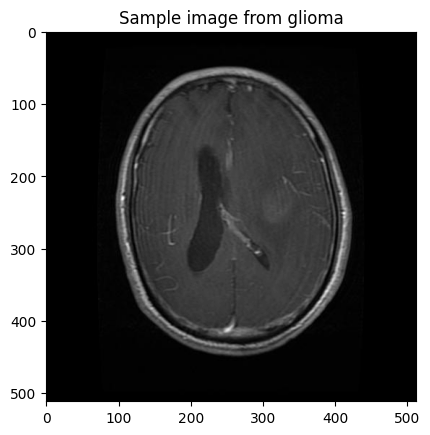

Category: meningioma, Number of images: 1339


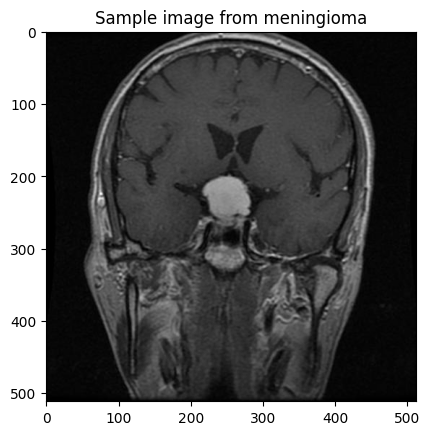

Category: notumor, Number of images: 1595


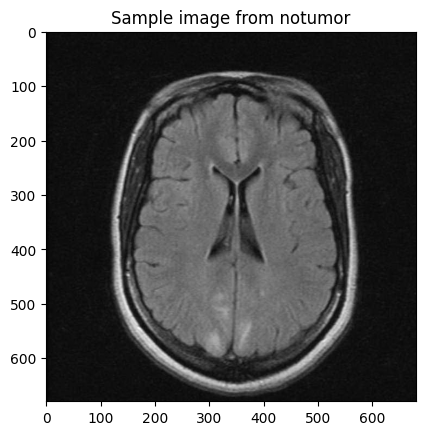

Category: pituitary, Number of images: 1457


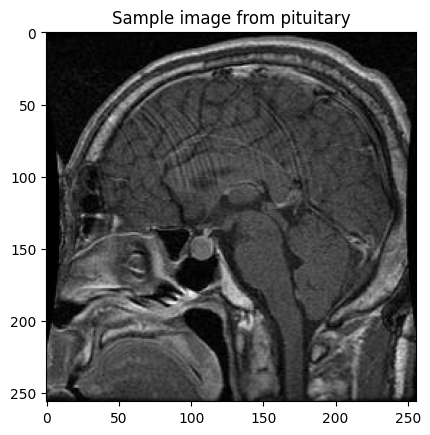

In [14]:
for category in categories:
    path = os.path.join(train_dir, category)
    images = os.listdir(path)
    if images:  # Ensure there are images in the category
        print(f"Category: {category}, Number of images: {len(images)}")
        sample_image_path = os.path.join(path, images[0])
        sample_image = tf.keras.preprocessing.image.load_img(sample_image_path, color_mode="grayscale")
        plt.imshow(sample_image, cmap='gray')
        plt.title(f"Sample image from {category}")
        plt.show()
    else:
        print(f"No images found in category: {category}")

## Data Preparation

In [15]:
def prepare_data(directory, categories, img_size):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = tf.keras.preprocessing.image.load_img(os.path.join(path, img), target_size=(img_size, img_size), color_mode="grayscale")
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)
                img_array = img_array / 255.0
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Failed to read image: {os.path.join(path, img)}, error: {e}")  # Debug statement
    return np.array(data), np.array(labels)

# Load and preprocess data
X_train, y_train = prepare_data(train_dir, categories, img_size)
X_test, y_test = prepare_data(test_dir, categories, img_size)
y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

In [16]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 5711
Testing samples: 1311


In [17]:
print(f"Training class distribution: {Counter(np.argmax(y_train, axis=1))}")
print(f"Testing class distribution: {Counter(np.argmax(y_test, axis=1))}")

Training class distribution: Counter({2: 1595, 3: 1457, 1: 1339, 0: 1320})
Testing class distribution: Counter({2: 405, 1: 306, 0: 300, 3: 300})


### Data Augmentation

In [18]:
datagen = ImageDataGenerator(
    rotation_range=30,  # Increase rotation range
    width_shift_range=0.2,  # Increase shift range
    height_shift_range=0.2,
    shear_range=0.2,  # Increase shear
    zoom_range=0.2,  # Increase zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)


### Capsule Network Model

In [19]:
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings
        self.kernel = None

    def build(self, input_shape):
        assert len(input_shape) == 3, "Input shape should be [None, input_capsule_num, input_capsule_dim]"
        self.input_capsule_num = input_shape[1]
        self.input_capsule_dim = input_shape[2]
        self.kernel = self.add_weight(shape=(self.input_capsule_num, self.num_capsules, self.input_capsule_dim, self.dim_capsules),
                                      initializer='glorot_uniform',
                                      name='capsule_kernel')

    def call(self, inputs, training=None):
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 2), -1)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1, 1])
        inputs_hat = tf.reduce_sum(inputs_tiled * self.kernel, axis=3)

        b = tf.zeros(shape=[tf.shape(inputs)[0], self.input_capsule_num, self.num_capsules, 1])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = tf.reduce_sum(c * inputs_hat, axis=1, keepdims=True)
            outputs = tf.squeeze(tf.nn.l2_normalize(outputs, -1), axis=1)
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * tf.expand_dims(outputs, 1), -1, keepdims=True)

        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsules, self.dim_capsules)

class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + 1e-9)

### Define the CapsNet model

In [20]:
input_image = layers.Input(shape=(img_size, img_size, 1))
conv1 = layers.Conv2D(128, (9, 9), activation='relu')(input_image)
conv2 = layers.Conv2D(128, (9, 9), strides=(2, 2), activation='relu')(conv1)
primary_caps = layers.Conv2D(32 * 4, (9, 9), activation='relu')(conv2)
primary_caps_reshape = layers.Reshape((-1, 128))(primary_caps)

print("Shape of primary_caps:", primary_caps.shape)

Shape of primary_caps: (None, 48, 48, 128)


### Adjust reshape layer based on printed shape

In [21]:
capsule = CapsuleLayer(num_capsules=len(categories), dim_capsules=16)(primary_caps_reshape)
output = Length()(capsule)

model = models.Model(inputs=input_image, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 128)     10496     
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       1327232   
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1327232   
                                                                 
 reshape (Reshape)           (None, 2304, 128)         0         
                                                                 
 capsule_layer (CapsuleLaye  (None, 4, 16)             18874368  
 r)                                                              
                                                             

In [22]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

## Training the Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)

Epoch 1/50
 78/178 [============>.................] - ETA: 1:04:52 - loss: 1.3861 - accuracy: 0.2412

### Save the model

In [ ]:
model.save("capsnet_brain_tumor_model.h5")

In [ ]:
model.save('capsnet_brain_tumor_model.keras')

### Evaluate the model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Generate classification report

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=categories))

### Confusion matrix

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)